### DNN跟学 [PyTorch深度学习：深度神经网络（DNN）](https://www.bilibili.com/video/BV1Z8411R7PH/?share_source=copy_web&vd_source=43c4eb4ed8da935694eaeb473fd0f6cb)

#### 一、pytorch介绍

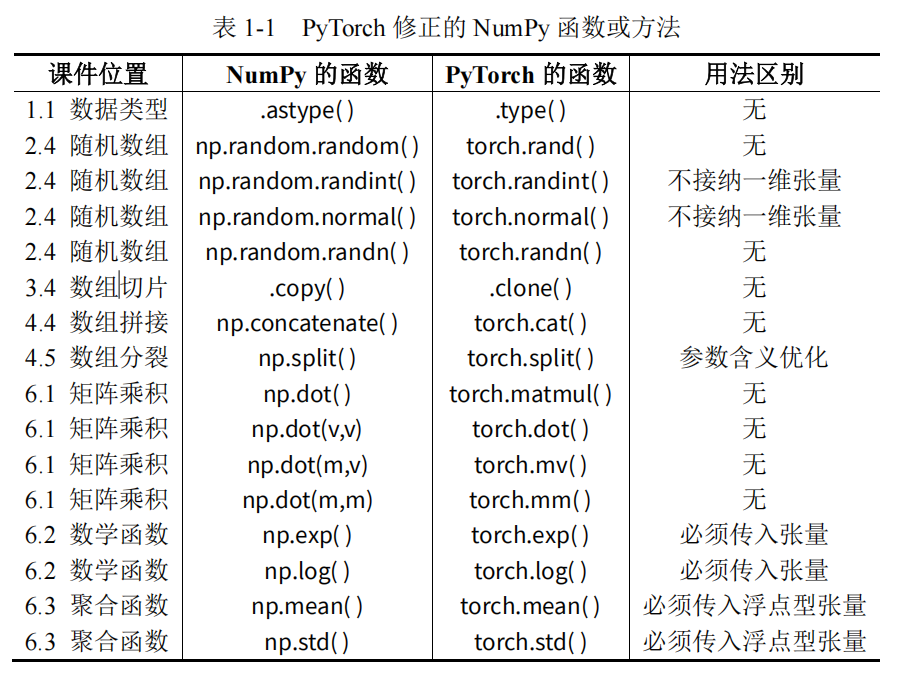

In [40]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision import transforms
from torchvision import datasets
import matplotlib.pyplot as plt
# 展示高清图
from matplotlib_inline import backend_inline
backend_inline.set_matplotlib_formats('svg')
import numpy as np
import pandas as pd

##### GPU存储计算

In [14]:
# 默认的张量存储在 CPU 上
ts1 = torch.randn(3,4)
print(ts1)
# 移动到 GPU 上
ts2 = ts1.to('cuda:0')
print(ts2)
# 也可以使用 .cuda() 方法

tensor([[-0.4206, -0.1874,  0.3091,  0.6586],
        [-0.9018, -0.1758, -0.6683, -0.0137],
        [-1.4334,  1.5696,  0.5221,  0.8690]])
tensor([[-0.4206, -0.1874,  0.3091,  0.6586],
        [-0.9018, -0.1758, -0.6683, -0.0137],
        [-1.4334,  1.5696,  0.5221,  0.8690]], device='cuda:0')


前向传播与反向传播一次时，有三种情况：  
⚫ 批量梯度下降（Batch Gradient Descent，BGD），把所有样本一次性输入进
网络，这种方式计算量开销很大，速度也很慢。  
⚫ 随机梯度下降（Stochastic Gradient Descent，SGD），每次只把一个样本输
入进网络，每计算一个样本就更新参数。这种方式虽然速度比较快，但是
收敛性能差，可能会在最优点附近震荡，两次参数的更新也有可能抵消。    
⚫ 小批量梯度下降（Mini-Batch Gradient Decent，MBGD）是为了中和上面
二者而生，这种办法把样本划分为若干个批，按批来更新参数。    

#### 二、批量梯度下降

##### 1. 准备数据集
将 arr 数组转为了 np.float32 类型这一步必不可少，没有的话计算过程会出现一些数据类型不兼容的情况     


In [25]:
# 准备数据集
df = pd.read_csv('resoures\DNN\DNN_Data.csv', index_col=0) # 导入数据
arr = df.values # Pandas 对象退化为 NumPy 数组
arr = arr.astype(np.float32) # 转为 float32 类型数组
ts = torch.tensor(arr) # 数组转为张量
ts = ts.to('cuda') # 把训练集搬到 cuda 上
print(ts.shape)
# 划分训练集与测试集
train_size = int(len(ts) * 0.7) # 训练集的样本数量
test_size = len(ts) - train_size # 测试集的样本数量
ts = ts[ torch.randperm( ts.size(0) ) , : ] # 打乱样本的顺序
train_Data = ts[ : train_size , : ] # 训练集样本
test_Data = ts[ train_size : , : ] # 测试集样本
train_Data.shape, test_Data.shape

torch.Size([759, 9])


(torch.Size([531, 9]), torch.Size([228, 9]))

##### 2. 搭建神经网络

In [ ]:
class DNN(nn.Module):
   def __init__(self):
      ''' 搭建神经网络各层 '''
      super(DNN,self).__init__()
      self.net = nn.Sequential( # 按顺序搭建各层
      nn.Linear(8, 32), nn.Sigmoid(), # 第 1 层：全连接层
      nn.Linear(32, 8), nn.Sigmoid(), # 第 2 层：全连接层
      nn.Linear(8, 4), nn.Sigmoid(), # 第 3 层：全连接层
      nn.Linear(4, 1), nn.Sigmoid() # 第 4 层：全连接层
      )
   def forward(self, x):
      ''' 前向传播 '''
      y = self.net(x) # x 即输入数据
      return y # y 即输出数据
   
model = DNN().to('cuda:0') # 创建子类的实例，并搬到 GPU 上
print(model) # 查看该实例的各层

##### 3. 参数的选择

In [ ]:
# 损失函数的选择
loss_fn = nn.BCELoss(reduction='mean')
# 优化算法的选择
learning_rate = 0.005 # 设置学习率
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
epochs = 5000 # 迭代次数

##### 4. 训练网络

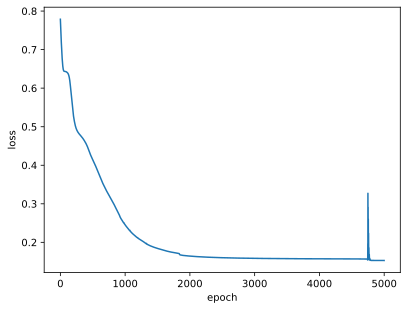

In [ ]:
# 训练网络
losses = [] # 记录损失函数变化的列表
# 给训练集划分输入与输出
X = train_Data[ : , : -1 ] # 前 8 列为输入特征
Y = train_Data[ : , -1 ].reshape((-1,1)) # 后 1 列为输出特征
# 此处的.reshape((-1,1))将一阶张量升级为二阶张量
for epoch in range(epochs):
    Pred = model(X) # 一次前向传播（批量）
    loss = loss_fn(Pred, Y) # 计算损失函数
    losses.append(loss.item()) # 记录损失函数的变化
    optimizer.zero_grad() # 清理上一轮滞留的梯度
    loss.backward() # 一次反向传播
    optimizer.step() # 优化内部参数
 
Fig = plt.figure()
plt.plot(range(epochs), losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

##### 5. 测试网络
注意，真实的输出特征都是 0 或 1，因此这里需要对网络预测的输出 Pred 进行处理，   
Pred 大于 0.5 的部分全部置 1，小于 0.5 的部分全部置 0

In [ ]:
# 测试网络
# 给测试集划分输入与输出
X = test_Data[ : , : -1 ] # 前 8 列为输入特征
Y = test_Data[ : , -1 ].reshape((-1,1)) # 后 1 列为输出特征
with torch.no_grad(): # 该局部关闭梯度计算功能，因为测试时不需要反向传播
    Pred = model(X) # 一次前向传播（批量）
    Pred[Pred>=0.5] = 1
    Pred[Pred<0.5] = 0
    correct = torch.sum( (Pred == Y).all(1) ) # 预测正确的样本
    total = Y.size(0) # 全部的样本数量
    print(f'测试集精准度: {100*correct/total} %')

测试集精准度: 73.24561309814453 %


#### 三、小批量梯度下降

##### 1. 制作数据集 
在封装我们的数据集时，必须继承实用工具（utils）中的 DataSet 的类，这个过程需要重写__init__、__getitem__、__len__三个方法，  
分别是为了加载数据集、获取数据索引、获取数据总量。  
实用工具（utils）里的 DataLoader 可以在接下来的训练中进行小批次的载入数据，shuffle 用于在每一个 epoch 内先洗牌再分批。

In [ ]:
# 制作数据集
class MyData(Dataset): # 继承 Dataset 类
    def __init__(self, filepath):
        df = pd.read_csv(filepath, index_col=0) # 导入数据
        arr = df.values # 对象退化为数组
        arr = arr.astype(np.float32) # 转为 float32 类型数组
        ts = torch.tensor(arr) # 数组转为张量
        ts = ts.to('cuda') # 把训练集搬到 cuda 上
        self.X = ts[ : , : -1 ] # 前 8 列为输入特征
        self.Y = ts[ : , -1 ].reshape((-1,1)) # 后 1 列为输出特征
        self.len = ts.shape[0] # 样本的总数
        
    def __getitem__(self, index):
        """ 该方法返回一个样本的输入与输出 """
        return self.X[index], self.Y[index]
    
    def __len__(self):
        """ 该方法返回样本的总数 """
        return self.len
# 划分训练集与测试集
Data = MyData('resoures\DNN\DNN_Data.csv')
train_size = int(len(Data) * 0.7) # 训练集的样本数量
test_size = len(Data) - train_size # 测试集的样本数量
train_Data, test_Data = random_split(Data, [train_size, test_size]) # 随机划分训练集与测试集
# 批次加载器
train_loader = DataLoader(dataset=train_Data, shuffle=True, batch_size=128)
test_loader = DataLoader(dataset=test_Data, shuffle=False, batch_size=64)

##### 2. 搭建神经网络

In [ ]:
class DNN(nn.Module):
 def __init__(self):
    ''' 搭建神经网络各层 '''
    super(DNN,self).__init__()
    self.net = nn.Sequential( # 按顺序搭建各层
    nn.Linear(8, 32), nn.Sigmoid(), # 第 1 层：全连接层
    nn.Linear(32, 8), nn.Sigmoid(), # 第 2 层：全连接层
    nn.Linear(8, 4), nn.Sigmoid(), # 第 3 层：全连接层
    nn.Linear(4, 1), nn.Sigmoid() # 第 4 层：全连接层
    )
 def forward(self, x):
    ''' 前向传播 '''
    y = self.net(x) # x 即输入数据
    return y # y 即输出数据
 
model = DNN().to('cuda:0') # 创建子类的实例，并搬到 GPU 上
model # 查看该实例的各层

DNN(
  (net): Sequential(
    (0): Linear(in_features=8, out_features=32, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=32, out_features=8, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=8, out_features=4, bias=True)
    (5): Sigmoid()
    (6): Linear(in_features=4, out_features=1, bias=True)
    (7): Sigmoid()
  )
)

##### 3. 训练模型

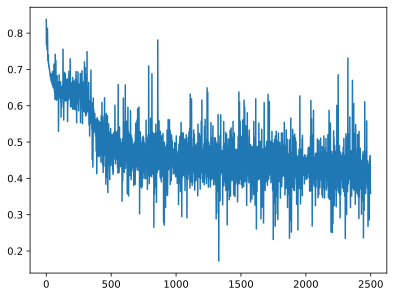

In [37]:
# 损失函数的选择
loss_fn = nn.BCELoss(reduction='mean')
# 优化算法的选择
learning_rate = 0.005 # 设置学习率
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# 训练网络
epochs = 500
losses = [] # 记录损失函数变化的列表
for epoch in range(epochs):
    for (x, y) in train_loader: # 获取小批次的 x 与 y
        Pred = model(x) # 一次前向传播（小批量）
        loss = loss_fn(Pred, y) # 计算损失函数
        losses.append(loss.item()) # 记录损失函数的变化
        optimizer.zero_grad() # 清理上一轮滞留的梯度
        loss.backward() # 一次反向传播
        optimizer.step() # 优化内部参数
Fig = plt.figure()
plt.plot(range(len(losses)), losses)
plt.show()

In [38]:
# 测试网络
correct = 0
total = 0
with torch.no_grad(): # 该局部关闭梯度计算功能
    for (x, y) in test_loader: # 获取小批次的 x 与 y
        Pred = model(x) # 一次前向传播（小批量）
        Pred[Pred>=0.5] = 1
        Pred[Pred<0.5] = 0
        correct += torch.sum( (Pred == y).all(1) )
        total += y.size(0)
print(f'测试集精准度: {100*correct/total} %')

测试集精准度: 76.75438690185547 %


#### 四、手写数字识别
手写数字识别数据集（MNIST）是机器学习领域的标准数据集，它被称为机器学习领域的“Hello World”，只因任何 AI 算法都可以用此标准数据集进行检验

##### 1. 制作数据集
需要在 torchvision 库中分别下载训练集与测试集，因此需要从torchvision 库中导入 datasets 以下载数据集，下载前需要借助 torchvision 库中的 transforms 进行图像转换，将数据集变为张量，并调整数据集的统计分布    
由于不需要手动构建数据集，因此不导入 utils 中的 Dataset；   
又由于训练集与测试集是分开下载的，因此不导入 utils 中的 random_split。

In [ ]:
# 在下载数据集之前，要设定转换参数：transform，该参数里解决两个问题：
# ⚫ ToTensor：将图像数据转为张量，且调整三个维度的顺序为 C*W*H；C
# 表示通道数，二维灰度图像的通道数为 1，三维 RGB 彩图的通道数为 3。
# ⚫ Normalize：将神经网络的输入数据转化为标准正态分布，训练更好；根
# 据统计计算，MNIST 训练集所有像素的均值是 0.1307、标准差是 0.3081。
# 数据集转换参数
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize(0.1307, 0.3081)
])
# 下载训练集与测试集
train_Data = datasets.MNIST(
    root = 'resoures\dataset', # 下载路径
    train = True, # 是 train 集
    download = True, # 如果该路径没有该数据集，就下载
    transform = transform # 数据集转换参数
)
test_Data = datasets.MNIST(
    root = 'resoures\dataset', # 下载路径
    train = False, # 是 test 集
    download = True, # 如果该路径没有该数据集，就下载
    transform = transform # 数据集转换参数
)
# 批次加载器
train_loader = DataLoader(train_Data, shuffle=True, batch_size=64)
test_loader = DataLoader(test_Data, shuffle=False, batch_size=64)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:11<00:00, 874kB/s] 


Extracting resoures\dataset\MNIST\raw\train-images-idx3-ubyte.gz to resoures\dataset\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 107kB/s]


Extracting resoures\dataset\MNIST\raw\train-labels-idx1-ubyte.gz to resoures\dataset\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:02<00:00, 688kB/s] 


Extracting resoures\dataset\MNIST\raw\t10k-images-idx3-ubyte.gz to resoures\dataset\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 1.38MB/s]

Extracting resoures\dataset\MNIST\raw\t10k-labels-idx1-ubyte.gz to resoures\dataset\MNIST\raw



##### 2. 搭建神经网络

In [ ]:
class DNN(nn.Module):
   def __init__(self):
      ''' 搭建神经网络各层 '''
      super(DNN,self).__init__()
      self.net = nn.Sequential( # 按顺序搭建各层
      nn.Flatten(), # 把图像铺平成一维
      nn.Linear(784, 512), nn.ReLU(), # 第 1 层：全连接层
      nn.Linear(512, 256), nn.ReLU(), # 第 2 层：全连接层
      nn.Linear(256, 128), nn.ReLU(), # 第 3 层：全连接层
      nn.Linear(128, 64), nn.ReLU(), # 第 4 层：全连接层
      nn.Linear(64, 10) # 第 5 层：全连接层
      )
   def forward(self, x):
      ''' 前向传播 '''
      y = self.net(x) # x 即输入数据
      return y # y 即输出数据
model = DNN().to('cuda:0') # 创建子类的实例，并搬到 GPU 上
model # 查看该实例的各层

DNN(
  (net): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=512, bias=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU()
    (5): Linear(in_features=256, out_features=128, bias=True)
    (6): ReLU()
    (7): Linear(in_features=128, out_features=64, bias=True)
    (8): ReLU()
    (9): Linear(in_features=64, out_features=10, bias=True)
  )
)

##### 3. 训练网络
给优化器了一个新参数 momentum（动量），它使梯度下降算法有了力与惯性，该方法给人的感觉就像是小球在地面上滚动一样。

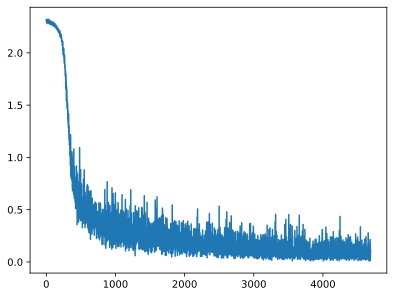

In [43]:
# 损失函数的选择
loss_fn = nn.CrossEntropyLoss() # 自带 softmax 激活函数
# 优化算法的选择
learning_rate = 0.01 # 设置学习率
optimizer = torch.optim.SGD(
    model.parameters(),
    lr = learning_rate,
    momentum = 0.5
)
# 训练网络
epochs = 5
losses = [] # 记录损失函数变化的列表
for epoch in range(epochs):
    for (x, y) in train_loader: # 获取小批次的 x 与 y
        x, y = x.to('cuda:0'), y.to('cuda:0')
        Pred = model(x) # 一次前向传播（小批量）
        loss = loss_fn(Pred, y) # 计算损失函数
        losses.append(loss.item()) # 记录损失函数的变化
        optimizer.zero_grad() # 清理上一轮滞留的梯度
        loss.backward() # 一次反向传播
        optimizer.step() # 优化内部参数
Fig = plt.figure()
plt.plot(range(len(losses)), losses)
plt.show()

##### 4. 测试网络
a, b = torch.max(Pred.data, dim=1)的意思是，找出 Pred 每一行里的最大值，    
数值赋给 a，所处位置赋给 b。因此上述代码里的 predicted 就相当于把独热编码转换回了普通的阿拉伯数字，     
这样一来可以直接与 y 进行比较。例如：     
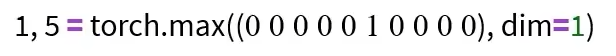  
由于此处 predicted 与 y 是一阶张量，因此 correct 行的结尾不能加.all(1)。

In [44]:
# 测试网络
correct = 0
total = 0
with torch.no_grad(): # 该局部关闭梯度计算功能
    for (x, y) in test_loader: # 获取小批次的 x 与 y
        x, y = x.to('cuda:0'), y.to('cuda:0')
        Pred = model(x) # 一次前向传播（小批量）
        _, predicted = torch.max(Pred.data, dim=1)
        correct += torch.sum( (predicted == y) )
        total += y.size(0) 
print(f'测试集精准度: {100*correct/total} %')

测试集精准度: 97.04000091552734 %
